In [1]:
from abc import ABC, abstractmethod
import numpy as np
import pandas as pd
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.collections import LineCollection
from sklearn.metrics import roc_curve, auc, roc_auc_score
from scipy.stats import wasserstein_distance
from alons.testAUC.src.evaluate_auc import roc_drift_score

np.random.seed(2023)

# Generate valid and test set

In [2]:
def get_0_1_constrained_normal_distribution(μ, σ, N):
    ŷ = np.random.normal(μ, σ, N)
    is_between_0_and_1 = np.bitwise_and(ŷ<1, ŷ>0)
    return ŷ[is_between_0_and_1]


def simulate_model_results(N, μ_neg, μ_pos, σ):
    ŷ_neg = get_0_1_constrained_normal_distribution(μ_neg, σ, N)
    ŷ_pos = get_0_1_constrained_normal_distribution(μ_pos, σ, N)
    ŷ = np.concatenate((ŷ_neg, ŷ_pos))
    y = np.concatenate((np.zeros(len(ŷ_neg)), np.ones(len(ŷ_pos))))
    return y, ŷ

In [3]:
y_valid, ŷ_valid = simulate_model_results(N=10000, μ_neg=0.48, μ_pos=0.52, σ=0.02)

y_test = y_valid
ŷ_test = np.copy(ŷ_valid)
centered = ŷ_test - 0.5
ŷ_test = np.sign(centered) * np.abs(centered)**0.05 / 2 + 0.5

# Intra set metrics

In [4]:
class Perturbation(ABC):
    def __init__(self, pos_label=None, n_points=20):
        self.σs = np.linspace(0, 1, num=n_points, endpoint=True)
        self.pos_label = 1 if pos_label is None else pos_label

    def get_auc(self, y, ŷ):
        fpr, tpr, _ = roc_curve(y, ŷ, pos_label=self.pos_label)
        return auc(fpr, tpr)


    def get_auc_gain(self, original_auc, y, ŷ):
        auc = self.get_auc(y, ŷ)
        return auc / original_auc

    def _check_inputs(self, ŷ):
        if ŷ.min() < 0 or 1 < ŷ.max():
            raise Exception('Supports scores between 0 and 1 and the moment')

    @abstractmethod
    def _get_y_scoreδ(self, y_true, y_score, σ):
        raise NotImplementedError

    def _get_gain(self, original_auc, y, ŷ, σ):
        ŷ = self._get_y_scoreδ(y, ŷ, σ)
        return self.get_auc_gain(original_auc, y, ŷ)

    def __call__(self, y, ŷ):
        self._check_inputs(ŷ)
        original_auc = self.get_auc(y, ŷ)

        auc_gains = [self._get_gain(original_auc, y, ŷ, σ) for σ in self.σs]
        auc_gains = np.array(auc_gains)

        perturbation_auc = np.trapz(auc_gains) / len(auc_gains)
        return self.σs, auc_gains, perturbation_auc

In [5]:
class Robustness(Perturbation):
    def _get_y_scoreδ(self, y_true, y_score, σ):
        return np.random.normal(loc=y_score, scale=σ)

class Bias(Perturbation):
    def _get_y_scoreδ(self, y, ŷ, σ):
        is_pos = y == self.pos_label
        ŷ = np.copy(ŷ)
        ŷ[is_pos] -= σ
        return ŷ

In [6]:
class PlotROC:

    def __init__(self, colormap='viridis', linewidth=2, n_dots=20):
        self.colormap = colormap
        self.linewidth = linewidth
        self.n_dots = n_dots

    def _display_dots_for_selected_thresholds(self, fpr, tpr, thresholds, n_dots, axis):
        cmap = cm.get_cmap(self.colormap)
        norm = Normalize(vmin=thresholds.min(), vmax=thresholds.max())
        
        for thresh in np.linspace(thresholds.min(), thresholds.max(), n_dots):
            closest_idx = np.argmin(np.abs(thresholds - thresh))
            x, y = fpr[closest_idx], tpr[closest_idx]

            color = cmap(norm(thresh))
            axis.scatter(x, y, color=color, edgecolors='black', linewidths=0.5)


    def _get_corrected_fpr_tpr_thresholds(self, y, ŷ):
        fpr, tpr, thresholds = roc_curve(y, ŷ)
        assert thresholds[0] >= 1, "First threshold value is expected to be >= 1.0."
        thresholds[0] = 1
        return fpr, tpr, thresholds

    def _get_segments(self, fpr, tpr, thresholds):
        points = np.array([fpr, tpr]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        return segments

    def _get_lc(self, segments, thresholds):
        lc = LineCollection(segments, cmap=self.colormap, norm=plt.Normalize(0, 1))
        lc.set_array(thresholds)
        lc.set_linewidth(self.linewidth)
        return lc

    def __call__(self, y, ŷ, axis=None):
        if axis is None:
            fig, axis = plt.subplots(1, 1)

        fpr, tpr, thresholds = self._get_corrected_fpr_tpr_thresholds(y, ŷ)

        segments = self._get_segments(fpr, tpr, thresholds)
        lc = self._get_lc(segments, thresholds)

        axis.set_title(f"Threshold colored ROC")
        axis.add_collection(lc)
        cbar = plt.colorbar(lc, ax=axis)
        self._display_dots_for_selected_thresholds(fpr, tpr, thresholds, self.n_dots, axis)

        axis.set_xlim(0, 1)  # a bit wider to make space for labels
        axis.set_ylim(0.05, 1.0)
        axis.set_xlabel('False Positive Rate')
        axis.set_ylabel('True Positive Rate')

In [7]:
class Plot:
    def __init__(self, bins=30):
        self.fig, self.axs = plt.subplots(4, 1)
        self.bins = bins

    def _split_predictions(self, labels, predictions):
        is_pos = labels == 1
        ŷ_pos = predictions[is_pos]
        ŷ_neg = predictions[~is_pos]
        return ŷ_pos, ŷ_neg

    def plot_hist(self, y, ŷ, axis):
        ŷ_pos, ŷ_neg = self._split_predictions(y, ŷ)
        fpr, tpr, _ = roc_curve(y, ŷ)

        axis.hist(ŷ_neg, label='Negative Class', alpha=0.7, bins=self.bins)
        axis.hist(ŷ_pos, label='Positive Class', alpha=0.7, bins=self.bins)
        axis.set_title(f"ROCAUC: {auc(fpr, tpr):.2f}")
        axis.set_xlim([0, 1])
        axis.legend()
        axis.set_xlabel('Predictions')
        axis.set_ylabel('Frequency')

    def plot_curve(self, σs, auc_gains, pertubation_auc, type, axis):
        axis.set_ylim([0,1])
        axis.set_xlim([0, 1])
        axis.plot(σs, auc_gains)
        axis.set_title(f'{type} perturbation\nAUC: {pertubation_auc:.2f}')
        axis.set_xlabel('Perturbation scale')
        axis.set_ylabel('Perturbed-predictions AUC decay')

    def __call__(self, y, ŷ, file_name=None):
        self.plot_hist(y, ŷ, self.axs[0])

        PlotROC()(y, ŷ, self.axs[1])

        σs, auc_gains, perturbation_auc = Robustness()(y, ŷ)
        self.plot_curve(σs, auc_gains, perturbation_auc, 'Robustness', self.axs[2])

        σs, auc_gains, perturbation_auc = Bias()(y, ŷ)
        self.plot_curve(σs, auc_gains, perturbation_auc, 'Bias', self.axs[3])

        self.fig.set_size_inches(4, 10)
        plt.tight_layout()
        if file_name is not None:
            plt.savefig(f"{file_name}.png", bbox_inches='tight')
        plt.show()

Validation set


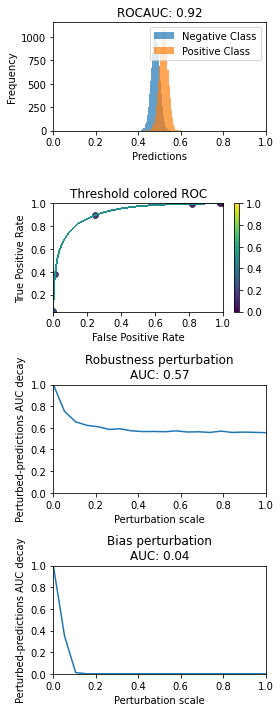

Test set


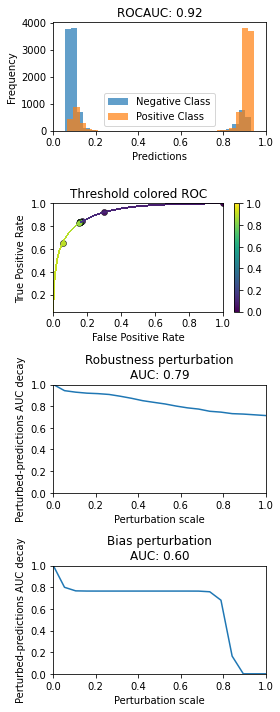

In [8]:
print("Validation set")
Plot()(y_valid, ŷ_valid, "valid_intra")

print("Test set")
Plot()(y_test, ŷ_test, "test_intra")

# Inter set metrics

In [9]:
class OTMatrix:
    def __init__(self, n_bins=20):
        self.n_bins = n_bins

    def _subsample(self, samples, n):
        return np.random.choice(samples, n, replace=False)

    def _adjust_sample_sizes(self, source_samples, target_samples):
        if len(source_samples) < len(target_samples):
            target_samples = self._subsample(target_samples, len(source_samples))
        elif len(target_samples) < len(source_samples):
            source_samples = self._subsample(source_samples, len(target_samples))
        return source_samples, target_samples

    def _get_hists(self, source_samples, target_samples):
        source_samples, target_samples = self._adjust_sample_sizes(source_samples, target_samples)
        source_hist, source_bin_edges = np.histogram(source_samples, bins=self.n_bins)
        target_hist, target_bin_edges = np.histogram(target_samples, bins=self.n_bins)
        return source_hist, target_hist

    def __call__(self, y_valid, ŷ_valid, y_test, ŷ_test, verbose=False):
        ŷ_valid_0 = ŷ_valid[y_valid==0]
        ŷ_valid_1 = ŷ_valid[y_valid==1]
        ŷ_test_0 = ŷ_test[y_test==0]
        ŷ_test_1 = ŷ_test[y_test==1]

        v0t0 = wasserstein_distance(ŷ_valid_0, ŷ_test_0)
        v1t1 = wasserstein_distance(ŷ_valid_1, ŷ_test_1)
        v0v1 = wasserstein_distance(ŷ_valid_0, ŷ_valid_1)
        t0t1 = wasserstein_distance(ŷ_test_0, ŷ_test_1)
    
        costs = dict()
        costs['V1'] = {'V0': v0v1, 'T1': v1t1}
        costs['T0'] = {'V0': v0t0, 'T1': t0t1}
        df = pd.DataFrame.from_dict(costs)
        return df

In [10]:
costs = OTMatrix()(y_valid, ŷ_valid, y_test, ŷ_test)
costs = costs.round(2)
display(costs)
costs.to_latex()

,V1,T0
V0,0.04,0.38
T1,0.38,0.56


/tmp/ipykernel_74829/24788386.py:4: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  costs.to_latex()


'\\begin{tabular}{lrr}\n\\toprule\n{} &    V1 &    T0 \\\\\n\\midrule\nV0 &  0.04 &  0.38 \\\\\nT1 &  0.38 &  0.56 \\\\\n\\bottomrule\n\\end{tabular}\n'

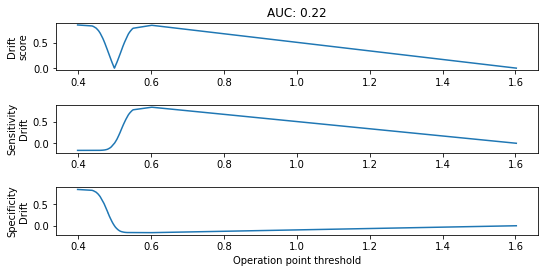

In [11]:
def plot_drift(y_valid, ŷ_valid, y_test, ŷ_test, bins=30):
    tpr_drift, fpr_drift, scores, th, result = roc_drift_score(y_valid, ŷ_valid, y_test, ŷ_test)

    drift_ax = plt.subplot(4, 1, 2)
    sensitivity_drift_ax = plt.subplot(4, 1, 3)
    specificity_drift_ax = plt.subplot(4, 1, 4)

    drift_ax.set_title(f'AUC: {result:.2f}')
    drift_ax.plot(th, scores)
    drift_ax.set_ylabel('Drift\nscore')

    sensitivity_drift_ax.plot(th, tpr_drift)
    sensitivity_drift_ax.set_ylabel('Sensitivity\nDrift')

    specificity_drift_ax.plot(th, -fpr_drift)
    specificity_drift_ax.set_xlabel('Operation point threshold')
    specificity_drift_ax.set_ylabel('Specificity\nDrift')

    plt.tight_layout()
    plt.gcf().set_size_inches(8, 5)
    plt.savefig("drift.png", bbox_inches='tight')
    plt.show()

plot_drift(y_valid, ŷ_valid, y_test, ŷ_test, bins=30)